MLP for Forward and Back Regression

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

df = pd.read_csv('/content/Book1.csv')
df.info()

dataset = df.values
X = dataset[:, 0:7]

input_dims = X.shape[1]
Y = dataset[:, 7:9]
print(Y)
output_dims = Y.shape[1]


def evaluate_model(model, X_val, Y_val):
    model.eval()
    with torch.no_grad():
        predictions = model(X_val)
        mae = mean_absolute_error(Y_val.cpu().detach().numpy(), predictions.cpu().detach().numpy())
        r2 = r2_score(Y_val.cpu().detach().numpy(), predictions.cpu().detach().numpy())
        return mae, r2

def train_model(model, criterion, optimizer, X_train, Y_train, epochs):
    for e in range(epochs):
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output.squeeze(), Y_train)
        loss.backward()
        optimizer.step()
    return model

class Model(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers, neurons, dropout_rate):
        super(Model, self).__init__()

        self.hidden_layers = nn.ModuleList()

        self.hidden_layers.append(nn.Linear(input_dim, neurons))
        for i in range(hidden_layers - 1):
            self.hidden_layers.append(nn.Linear(neurons, neurons))

        self.output_layer = nn.Linear(neurons, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x))
            x = self.dropout(x)
        x = self.output_layer(x)
        return x

hidden_layers = [2, 3, 4, 5]
neurons = [128, 256, 512, 1024]
dropout_rates = [0.2, 0.3, 0.5]
epochs_list = [100, 200, 300]
optimizers = [optim.SGD, optim.RMSprop, optim.Adam]
learning_rates = [0.01, 0.001, 0.0005]

kfold = KFold(n_splits = 10, shuffle = True)
best_mae, best_r2, best_mape = float('inf'), float('-inf'), float('inf')
best_params = {}

for hidden_layer in hidden_layers:
    for neuron in neurons:
        for dropout_rate in dropout_rates:
            for learning_rate in learning_rates:
                for epoch in epochs_list:
                    for opt in optimizers:
                        mae_scores, r2_scores = [], []
                        for train_index, val_index in kfold.split(X):
                            X_train, X_val = X[train_index], X[val_index]
                            Y_train, Y_val = Y[train_index], Y[val_index]

                            scaler = MinMaxScaler()
                            X_train = scaler.fit_transform(X_train)
                            X_val = scaler.fit_transform(X_val)

                            X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
                            Y_train = torch.tensor(Y_train, dtype=torch.float32).to(device)
                            X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
                            Y_val = torch.tensor(Y_val, dtype=torch.float32).to(device)

                            model = Model(input_dims, output_dims, hidden_layer, neuron, dropout_rate).to(device)
                            criterion = nn.SmoothL1Loss()
                            optimizer = opt(model.parameters(), lr=learning_rate, weight_decay=0.01)
                            model = train_model(model, criterion, optimizer, X_train, Y_train, epochs=epoch)
                            mae, r2 = evaluate_model(model, X_val, Y_val)
                            mae_scores.append(mae)
                            r2_scores.append(r2)

                        avg_mae, avg_r2 = np.mean(mae_scores), np.mean(r2_scores)
                        std_mae, std_r2 = np.std(mae_scores), np.std(r2_scores)

                        if avg_mae < best_mae and avg_r2 > best_r2 and avg_mape<best_mape:
                            best_mae, best_r2, best_mape = avg_mae, avg_r2, avg_mape
                            best_params = {'hidden_layers': hidden_layer, 'neurons': neuron, 'dropout_rate': dropout_rate, 'learning_rate': learning_rate, 'optimizer': opt, 'epochs': epoch}

print('Best Parameters: ', best_params)
print("Best Mean Absolute Error (MAE): ", best_mae)
print("Best Mean Absolute Percentage Error (MAPE): ", best_mape)
print('Best R^2 Score: ', best_r2)
print('Std of MAE: ', std_mae)
print('Std of MAPE: ', std_mape)
print('Std of R^2: ', std_r2)

Generative Models: VAE

Epoch 1, Loss: 0.9164183115305966
Epoch 2, Loss: 0.851671917797768
Epoch 3, Loss: 0.7912436192982817
Epoch 4, Loss: 0.7686631646874833
Epoch 5, Loss: 0.7620453548757997
Epoch 6, Loss: 0.7585890309451377
Epoch 7, Loss: 0.7477422638298714
Epoch 8, Loss: 0.7458809940782312
Epoch 9, Loss: 0.7436660520017964
Epoch 10, Loss: 0.7429643175373338
Epoch 11, Loss: 0.7345185288011211
Epoch 12, Loss: 0.7375983710158361
Epoch 13, Loss: 0.732202607474915
Epoch 14, Loss: 0.7295045199459547
Epoch 15, Loss: 0.7309461578930894
Epoch 16, Loss: 0.7246885952884203
Epoch 17, Loss: 0.7246330172231753
Epoch 18, Loss: 0.726001596614106
Epoch 19, Loss: 0.7226069487937509
Epoch 20, Loss: 0.7227467984369357
Epoch 21, Loss: 0.7170372784954228
Epoch 22, Loss: 0.7179027493685892
Epoch 23, Loss: 0.7113927545612806
Epoch 24, Loss: 0.7114900562861194
Epoch 25, Loss: 0.7119792258902772
Epoch 26, Loss: 0.7113852386605249
Epoch 27, Loss: 0.7062610020376232
Epoch 28, Loss: 0.7083982319048007
Epoch 29, Loss: 0.70381720547806

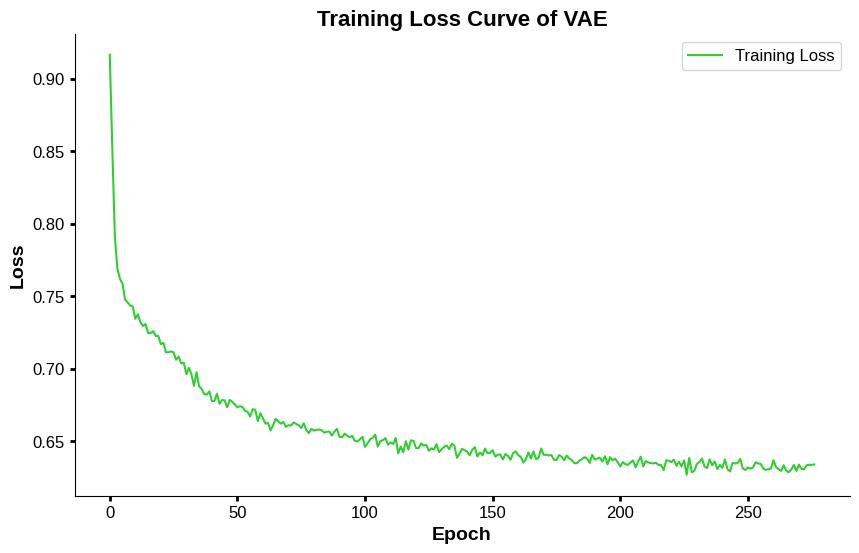

In [ ]:
import pandas as pd
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


df = pd.read_csv('/content/drive/MyDrive/Data for ML Project (2).csv')
dataset = df.values

X = dataset[:, 0:7]
Y = dataset[:, 7:9]

X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(X)
Y_scaled = Y_scaler.fit_transform(Y)

X_tensor = torch.tensor(X_scaled, dtype = torch.float32)
Y_tensor = torch.tensor(Y_scaled, dtype = torch.float32)

data = TensorDataset(Y_tensor, X_tensor)
data_loader = DataLoader(data, batch_size = 32, shuffle = True)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(2, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc21 = nn.Linear(128, 30)
        self.fc22 = nn.Linear(128, 30)
        self.dropout = nn.Dropout(p=0.2)

        self.fc4 = nn.Linear(30, 128)
        self.fc5 = nn.Linear(128, 256)
        self.fc6 = nn.Linear(256, 512)
        self.fc7 = nn.Linear(512, 7)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h1 = self.dropout(h1)
        h2 = F.relu(self.fc2(h1))
        h2 = self.dropout(h2)
        h3 = F.relu(self.fc3(h2))
        h3 = self.dropout(h3)
        return self.fc21(h3), self.fc22(h3)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h4 = F.relu(self.fc4(z))
        h4 = self.dropout(h4)
        h5 = F.relu(self.fc5(h4))
        h5 = self.dropout(h5)
        h6 = F.relu(self.fc6(h5))
        h6 = self.dropout(h6)
        return torch.sigmoid(self.fc7(h6))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + 0.001*KLD

def train(model, data_loader, epochs=100, patience = 50):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.7)

    best_loss = float('inf')
    no_improve_epochs = 0
    train_losses = []

    for epoch in range(epochs):
        train_loss = 0
        for batch_idx, (y, x) in enumerate(data_loader):
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(y)
            loss = vae_loss(recon_batch, x, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        avg_train_loss = train_loss / len(data_loader.dataset)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_train_loss}")

        if avg_train_loss < best_loss:
            best_loss = avg_train_loss
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1

        if no_improve_epochs >= patience:
            print(f"Early stopping at epoch {epoch+1}. No improvement in loss for {patience} consecutive epochs.")
            break

        scheduler.step()


    plt.rcParams["font.family"] = "Liberation Sans"
    plt.rcParams["font.size"] = 12
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', color = 'limegreen')
    plt.legend(loc='upper right')

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_tick_params(width = 2.0)
    ax.yaxis.set_tick_params(width = 2.0)
    plt.xlabel('Epoch', fontsize = 14, fontweight = 'bold')
    plt.ylabel('Loss', fontsize = 14, fontweight = 'bold')
    plt.title('Training Loss Curve of VAE', fontsize = 16, fontweight = 'bold')
    plt.legend()
    plt.show()

epochs = 500
vae = VAE()
train(vae, data_loader, epochs)

def generate_outputs(model, input_data, num_samples=10):
    model.eval()
    with torch.no_grad():
        input_data_scaled = Y_scaler.transform(input_data)
        mu, logvar = model.encode(torch.tensor(input_data_scaled, dtype=torch.float32))
        outputs = []
        for _ in range(num_samples):
            z = model.reparameterize(mu, logvar)
            output = model.decode(z)
            output = X_scaler.inverse_transform(output.numpy())
            outputs.append(output)
    return outputs

Generative model; CVAE

Epoch 1, Loss: 0.8739498674053036
Epoch 2, Loss: 0.4575948268175125
Epoch 3, Loss: 0.2510669133434557
Epoch 4, Loss: 0.17165491974925343
Epoch 5, Loss: 0.13304705101333253
Epoch 6, Loss: 0.10096491750789015
Epoch 7, Loss: 0.09270469288099302
Epoch 8, Loss: 0.08504771354467902
Epoch 9, Loss: 0.08121464472927459
Epoch 10, Loss: 0.07532890676839711
Epoch 11, Loss: 0.07186503478721397
Epoch 12, Loss: 0.06463264622916914
Epoch 13, Loss: 0.06936592853640856
Epoch 14, Loss: 0.06315266841078458
Epoch 15, Loss: 0.05818536979694889
Epoch 16, Loss: 0.0646235839246887
Epoch 17, Loss: 0.056698209516806146
Epoch 18, Loss: 0.0542244941812672
Epoch 19, Loss: 0.05619177502924449
Epoch 20, Loss: 0.05327998137433235
Epoch 21, Loss: 0.05256224444059476
Epoch 22, Loss: 0.049622851589771165
Epoch 23, Loss: 0.04746826181877149
Epoch 24, Loss: 0.04631047979099293
Epoch 25, Loss: 0.04455070646658336
Epoch 26, Loss: 0.048727506133791516
Epoch 27, Loss: 0.054421604343064846
Epoch 28, Loss: 0.042521592127541974
E

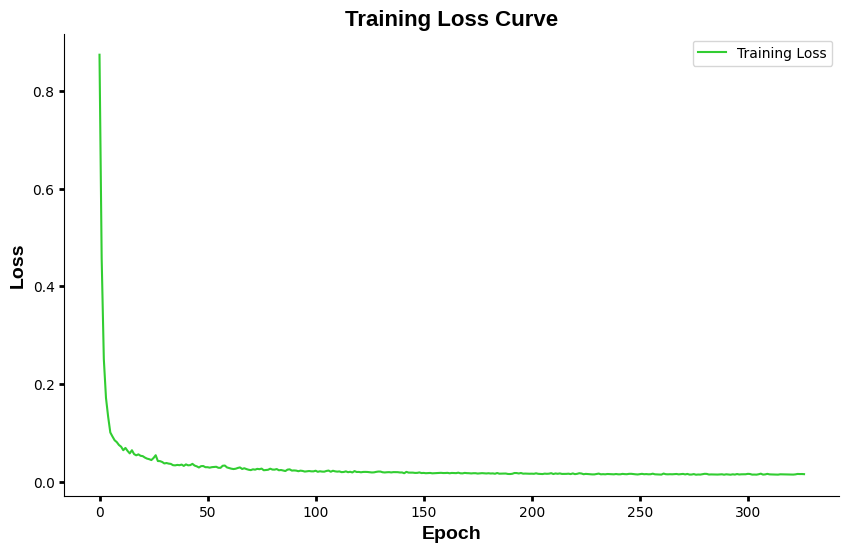

In [ ]:
import pandas as pd
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


df = pd.read_csv('/content/drive/MyDrive/Data for ML Project (2).csv')
dataset = df.values

X = dataset[:, 0:7]
Y = dataset[:, 7:9]

X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
X_scaled = X_scaler.fit_transform(X)
Y_scaled = Y_scaler.fit_transform(Y)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
Y_tensor = torch.tensor(Y_scaled, dtype=torch.float32)

data = TensorDataset(Y_tensor, X_tensor)
data_loader = DataLoader(data, batch_size=32, shuffle=True)

class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()

        self.fc1 = nn.Linear(9, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc21 = nn.Linear(128, 30)
        self.fc22 = nn.Linear(128, 30)
        self.dropout = nn.Dropout(p=0.2)

        self.fc4 = nn.Linear(32, 128)
        self.fc5 = nn.Linear(128, 256)
        self.fc6 = nn.Linear(256, 512)
        self.fc7 = nn.Linear(512, 7)

    def encode(self, x, condition):
        combined = torch.cat([x, condition], 1)
        h1 = F.relu(self.fc1(combined))
        h2 = F.relu(self.fc2(self.dropout(h1)))
        h3 = F.relu(self.fc3(self.dropout(h2)))
        return self.fc21(h3), self.fc22(h3)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z, condition):
        combined = torch.cat([z, condition], 1)
        h4 = F.relu(self.fc4(combined))
        h5 = F.relu(self.fc5(self.dropout(h4)))
        h6 = F.relu(self.fc6(self.dropout(h5)))
        return torch.sigmoid(self.fc7(self.dropout(h6)))

    def forward(self, x, condition):
        mu, logvar = self.encode(x, condition)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, condition), mu, logvar

def vae_loss(recon_x, x, mu, logvar):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + 0.001 * KLD

def train(model, data_loader, epochs=100, patience=50):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.7)

    best_loss = float('inf')
    no_improve_epochs = 0
    train_losses = []


    for epoch in range(epochs):
        train_loss = 0
        for batch_idx, (y, x) in enumerate(data_loader):
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(x, y)
            loss = vae_loss(recon_batch, x, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()

        avg_train_loss = train_loss / len(data_loader.dataset)
        train_losses.append(avg_train_loss)

        print(f'Epoch {epoch+1}, Loss: {avg_train_loss}')

        if avg_train_loss<best_loss:
          best_loss = avg_train_loss
          no_improve_epochs = 0
        else:
          no_improve_epochs += 1

        if no_improve_epochs >= patience:
          print(f"Early stopping at epoch {epoch+1}. No improvement in loss for {patience} consequtive epochs")
          break

        scheduler.step()

    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', color = 'limegreen')

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_tick_params(width = 2.0)
    ax.yaxis.set_tick_params(width = 2.0)
    plt.xlabel('Epoch', fontsize = 14, fontweight = 'bold', fontname='Liberation Sans')
    plt.ylabel('Loss', fontsize = 14, fontweight = 'bold', fontname='Liberation Sans')
    plt.title('Training Loss Curve', fontsize = 16, fontweight = 'bold', fontname='Liberation Sans')
    plt.legend()
    plt.show()

epochs = 500
cvae = CVAE()
train(cvae, data_loader, epochs)

def generate_outputs(model, input_data, num_samples=10):
    model.eval()
    with torch.no_grad():
        input_data_scaled = Y_scaler.transform(input_data)
        conditions = torch.tensor(input_data_scaled, dtype=torch.float32)
        outputs = []
        for _ in range(num_samples):
            mu, logvar = model.encode(torch.zeros((conditions.shape[0], 7), dtype=torch.float32), conditions)
            z = model.reparameterize(mu, logvar)
            output = model.decode(z, conditions)
            output = X_scaler.inverse_transform(output.numpy())
            outputs.append(output)
    return outputs